#### Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional, Any
import sys
import os

#### Adjust path as needed

In [2]:
# Add parent directory to path to import the cache modules
# sys.path.append('../')  # Adjust if needed to point to your parent folder

#### Import compression method implementations

In [3]:
# Import the cache implementations
from hf_cache import KNormCache
from leverage_scores_cache import SLSCache, LevScoreKVCache

#### Random seeds

In [4]:
# Set random seed for reproducibility
# torch.manual_seed(42)
# np.random.seed(42)

#### Functions for evaluations

In [5]:
# Utility functions for evaluation
def generate_synthetic_kv_data(
    batch_size: int = 1,
    num_heads: int = 4,
    seq_len: int = 1000,
    head_dim: int = 64,
    correlation: float = 0.5
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Generate synthetic key, value, and query data with controlled properties.
    
    Args:
        batch_size: Number of batches
        num_heads: Number of attention heads
        seq_len: Sequence length
        head_dim: Dimension of head vectors
        correlation: Correlation factor between different tokens
        
    Returns:
        keys: Tensor of shape [batch_size, num_heads, seq_len, head_dim]
        values: Tensor of shape [batch_size, num_heads, seq_len, head_dim]
        query: Tensor of shape [batch_size, num_heads, 1, head_dim]
    """
    # Create a base matrix that introduces correlation between tokens
    base_k = torch.randn(batch_size, num_heads, 1, head_dim)
    base_v = torch.randn(batch_size, num_heads, 1, head_dim)
    
    # Generate individual token vectors with correlation to the base
    rand_k = torch.randn(batch_size, num_heads, seq_len, head_dim)
    keys = correlation * base_k + (1 - correlation) * rand_k
    
    rand_v = torch.randn(batch_size, num_heads, seq_len, head_dim)
    values = correlation * base_v + (1 - correlation) * rand_v
    
    # Generate a query vector
    query = torch.randn(batch_size, num_heads, 1, head_dim)
    
    # Normalize vectors for stability
    keys = keys / torch.norm(keys, dim=-1, keepdim=True)
    values = values / torch.norm(values, dim=-1, keepdim=True)
    query = query / torch.norm(query, dim=-1, keepdim=True)
    
    return keys, values, query

In [6]:
def compute_attention_output(
    query: torch.Tensor,
    keys: torch.Tensor,
    values: torch.Tensor
) -> torch.Tensor:
    """
    Compute attention output for given query, keys, and values.
    
    Args:
        query: Tensor of shape [batch_size, num_heads, 1, head_dim]
        keys: Tensor of shape [batch_size, num_heads, seq_len, head_dim]
        values: Tensor of shape [batch_size, num_heads, seq_len, head_dim]
        
    Returns:
        output: Tensor of shape [batch_size, num_heads, 1, head_dim]
    """
    # Compute attention weights
    dk = keys.shape[-1]
    scores = torch.matmul(query, keys.transpose(-1, -2)) / (dk ** 0.5)
    attention = torch.softmax(scores, dim=-1)
    
    # Apply attention to values
    output = torch.matmul(attention, values)
    
    return output

In [7]:
def compute_distortion(
    original_output: torch.Tensor,
    compressed_output: torch.Tensor
) -> float:
    """
    Compute distortion between original and compressed outputs.
    
    Args:
        original_output: Original attention output
        compressed_output: Output after compression
        
    Returns:
        distortion: L2 norm of the difference
    """
    return torch.norm(original_output - compressed_output).item()

In [8]:
def evaluate_compression_method(
    cache_class,
    keys: torch.Tensor,
    values: torch.Tensor,
    query: torch.Tensor,
    window_length: int,
    max_length: int,
    cache_kwargs: Optional[Dict[str, Any]] = None
) -> float:
    """
    Evaluate a compression method by comparing original and compressed outputs.
    
    Args:
        cache_class: Cache class to evaluate
        keys: Key states
        values: Value states
        query: Query tensor
        window_length: Window length for the cache
        max_length: Maximum length for the cache
        cache_kwargs: Additional arguments for the cache
        
    Returns:
        distortion: Distortion measure
    """
    # Initialize cache
    if cache_kwargs is None:
        cache_kwargs = {}
    
    cache = cache_class(max_length=max_length, window_length=window_length, **cache_kwargs)
    
    # Add to cache
    cache.update(keys, values, layer_idx=0, cache_kwargs={'query': query})
    
    # Get compressed cache
    compressed_keys, compressed_values = cache.key_cache[0], cache.value_cache[0]
    
    # Compute original output
    original_output = compute_attention_output(query, keys, values)
    
    # Compute compressed output
    compressed_output = compute_attention_output(query, compressed_keys, compressed_values)
    
    # Compute distortion
    distortion = compute_distortion(original_output, compressed_output)
    
    return distortion

In [9]:
def evaluate_across_compression_ratios(
    methods: Dict[str, Any],
    keys: torch.Tensor,
    values: torch.Tensor,
    query: torch.Tensor,
    window_length: int,
    compression_ratios: List[float]
) -> Dict[str, List[float]]:
    """
    Evaluate multiple compression methods across different compression ratios.
    
    Args:
        methods: Dictionary mapping method names to classes
        keys: Key states
        values: Value states
        query: Query tensor
        window_length: Window length
        compression_ratios: List of compression ratios to evaluate
        
    Returns:
        results: Dictionary mapping method names to lists of distortion values
    """
    seq_len = keys.shape[2]
    results = {name: [] for name in methods}
    
    for alpha in compression_ratios:
        max_length = int(seq_len * alpha)
        
        # Skip if max_length is too small
        if max_length <= window_length:
            for name in methods:
                results[name].append(float('nan'))
            continue
        
        for name, method_class in methods.items():
            # Create method-specific kwargs if needed
            if name == 'LevScoreKV':
                kwargs = {'beta': 0.5, 'gamma': 1.0, 'n_samples': 10}
            elif name == 'SLS':
                kwargs = {'lambda_weight': 0.5, 'n_samples': 10}
            else:
                kwargs = {}
            
            distortion = evaluate_compression_method(
                method_class,
                keys,
                values,
                query,
                window_length,
                max_length,
                cache_kwargs=kwargs
            )
            
            results[name].append(distortion)
    
    return results

In [10]:
def plot_results(
    results: Dict[str, List[float]],
    compression_ratios: List[float],
    window_ratio: float
):
    """
    Plot distortion vs. compression ratio for different methods.
    
    Args:
        results: Results dictionary from evaluate_across_compression_ratios
        compression_ratios: List of compression ratios
        window_ratio: Ratio of window length to sequence length
    """
    plt.figure(figsize=(10, 6))
    
    # Define colors and markers for each method
    styles = {
        'KNorm': {'color': 'blue', 'marker': 'o', 'linestyle': '-'},
        'SLS': {'color': 'green', 'marker': 's', 'linestyle': '--'},
        'LevScoreKV': {'color': 'red', 'marker': '^', 'linestyle': '-.'}
    }
    
    for name, distortions in results.items():
        plt.plot(
            compression_ratios, 
            distortions, 
            label=name,
            **styles[name]
        )
    
    # Add vertical line for window boundary
    plt.axvline(x=window_ratio, color='gray', linestyle=':', label=f'Window Ratio ({window_ratio})')
    
    plt.xlabel('Compression Ratio (α)')
    plt.ylabel('Distortion')
    plt.title('Distortion vs. Compression Ratio for Different KV Cache Compression Methods')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

#### Evaluations with transformers

In [11]:
# Load real KV caches from a pre-trained model (optional)
def load_real_kv_caches(model_name='gpt2', seq_len=1000):
    """
    Load real KV caches from a pre-trained transformer model.
    This is optional and requires transformers library.
    
    Args:
        model_name: Name of the model to load
        seq_len: Sequence length to generate
        
    Returns:
        keys, values, query: Real KV caches and query
    """
    try:
        from transformers import AutoModelForCausalLM, AutoTokenizer
        
        # Load model and tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForCausalLM.from_pretrained(model_name)
        
        # Generate random text
        input_ids = torch.randint(100, 30000, (1, seq_len))
        input_ids = input_ids[:, :seq_len]  # Truncate to desired sequence length
        
        # Forward pass to get KV caches
        with torch.no_grad():
            outputs = model(input_ids, use_cache=True, output_attentions=True)
            
        # Extract past key values from the last layer
        past_key_values = outputs.past_key_values
        
        # Extract the last layer's KV cache
        layer_idx = -1  # Last layer
        keys = past_key_values[layer_idx][0]  # Keys
        values = past_key_values[layer_idx][1]  # Values
        
        # Generate a query from the model's embedding of the last token
        last_token_embedding = model.get_input_embeddings()(input_ids[:, -1:])
        query = model.transformer.h[0].attn.c_attn(last_token_embedding)
        query_parts = torch.split(query, model.config.n_embd, dim=-1)
        query = query_parts[0].view(1, model.config.n_head, 1, model.config.n_embd // model.config.n_head)
        
        return keys, values, query
    
    except ImportError:
        print("Transformers library not found. Using synthetic data instead.")
        return None, None, None
    except Exception as e:
        print(f"Error loading real KV caches: {e}")
        return None, None, None

#### Main evaluation function

In [12]:
# Main evaluation function
def run_evaluation(use_real_model=False):
    """
    Run the full evaluation comparing the three compression methods.
    
    Args:
        use_real_model: Whether to use a real pretrained model (requires transformers)
    """
    # Parameters
    batch_size = 1
    num_heads = 4
    seq_len = 1000
    head_dim = 64
    
    # If using a real model, try to load real KV caches
    if use_real_model:
        keys, values, query = load_real_kv_caches(seq_len=seq_len)
        
        # If loading failed, fall back to synthetic data
        if keys is None:
            use_real_model = False
    
    # Generate synthetic data if needed
    if not use_real_model:
        print("Using synthetic KV caches for evaluation")
        keys, values, query = generate_synthetic_kv_data(
            batch_size=batch_size,
            num_heads=num_heads,
            seq_len=seq_len,
            head_dim=head_dim,
            correlation=0.5
        )
    
    # Define methods to compare
    methods = {
        'KNorm': KNormCache,
        'SLS': SLSCache,
        'LevScoreKV': LevScoreKVCache
    }
    
    # Define compression ratios to evaluate
    compression_ratios = np.linspace(0.1, 1.0, 10)
    
    # Define window length as a percentage of sequence length
    window_ratio = 0.2
    window_length = int(seq_len * window_ratio)
    
    # Evaluate methods
    results = evaluate_across_compression_ratios(
        methods,
        keys,
        values,
        query,
        window_length,
        compression_ratios
    )
    
    # Plot results
    plot_results(results, compression_ratios, window_ratio)
    
    # Print numerical results
    print("Distortion values at different compression ratios:")
    print("Compression Ratio | KNorm | SLS | LevScoreKV")
    print("-" * 60)
    
    for i, alpha in enumerate(compression_ratios):
        knorm_val = results['KNorm'][i]
        sls_val = results['SLS'][i]
        levscore_val = results['LevScoreKV'][i]
        
        print(f"{alpha:.2f} | {knorm_val:.4f} | {sls_val:.4f} | {levscore_val:.4f}")
    
    return results, compression_ratios

#### Additional experiments

In [13]:
# Additional experiments
def run_parameter_sensitivity_analysis():
    """
    Analyze sensitivity of methods to their parameters.
    """
    # Parameters
    batch_size = 1
    num_heads = 4
    seq_len = 1000
    head_dim = 64
    
    # Generate synthetic data
    keys, values, query = generate_synthetic_kv_data(
        batch_size=batch_size,
        num_heads=num_heads,
        seq_len=seq_len,
        head_dim=head_dim,
        correlation=0.5
    )
    
    # Define window and compression parameters
    window_ratio = 0.2
    window_length = int(seq_len * window_ratio)
    alpha = 0.5
    max_length = int(seq_len * alpha)
    
    # Test SLS with different lambda values
    lambda_values = [0.0, 0.25, 0.5, 0.75, 1.0]
    sls_results = []
    
    for lambda_val in lambda_values:
        distortion = evaluate_compression_method(
            SLSCache,
            keys,
            values,
            query,
            window_length,
            max_length,
            cache_kwargs={'lambda_weight': lambda_val}
        )
        sls_results.append(distortion)
    
    # Test LevScoreKV with different beta values
    beta_values = [0.0, 0.25, 0.5, 0.75, 1.0]
    levscore_beta_results = []
    
    for beta_val in beta_values:
        distortion = evaluate_compression_method(
            LevScoreKVCache,
            keys,
            values,
            query,
            window_length,
            max_length,
            cache_kwargs={'beta': beta_val, 'gamma': 1.0}
        )
        levscore_beta_results.append(distortion)
    
    # Test LevScoreKV with different gamma values
    gamma_values = [0.1, 0.5, 1.0, 2.0, 5.0]
    levscore_gamma_results = []
    
    for gamma_val in gamma_values:
        distortion = evaluate_compression_method(
            LevScoreKVCache,
            keys,
            values,
            query,
            window_length,
            max_length,
            cache_kwargs={'beta': 0.5, 'gamma': gamma_val}
        )
        levscore_gamma_results.append(distortion)
    
    # Plot parameter sensitivity results
    plt.figure(figsize=(15, 5))
    
    # Plot SLS lambda sensitivity
    plt.subplot(1, 3, 1)
    plt.plot(lambda_values, sls_results, 'o-', color='green')
    plt.xlabel('Lambda Weight')
    plt.ylabel('Distortion')
    plt.title('SLS: Lambda Sensitivity')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot LevScoreKV beta sensitivity
    plt.subplot(1, 3, 2)
    plt.plot(beta_values, levscore_beta_results, 'o-', color='red')
    plt.xlabel('Beta')
    plt.ylabel('Distortion')
    plt.title('LevScoreKV: Beta Sensitivity')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot LevScoreKV gamma sensitivity
    plt.subplot(1, 3, 3)
    plt.plot(gamma_values, levscore_gamma_results, 'o-', color='red')
    plt.xlabel('Gamma')
    plt.ylabel('Distortion')
    plt.title('LevScoreKV: Gamma Sensitivity')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'lambda_values': lambda_values,
        'sls_results': sls_results,
        'beta_values': beta_values,
        'levscore_beta_results': levscore_beta_results,
        'gamma_values': gamma_values,
        'levscore_gamma_results': levscore_gamma_results
    }

In [14]:
def run_correlation_experiment():
    """
    Evaluate performance with different levels of token correlation.
    """
    # Parameters
    batch_size = 1
    num_heads = 4
    seq_len = 1000
    head_dim = 64
    
    # Define correlation values to test
    correlation_values = [0.0, 0.25, 0.5, 0.75, 0.9]
    
    # Define methods to compare
    methods = {
        'KNorm': KNormCache,
        'SLS': SLSCache,
        'LevScoreKV': LevScoreKVCache
    }
    
    # Define window and compression parameters
    window_ratio = 0.2
    window_length = int(seq_len * window_ratio)
    alpha = 0.5
    max_length = int(seq_len * alpha)
    
    # Initialize results dictionary
    correlation_results = {name: [] for name in methods}
    
    for correlation in correlation_values:
        # Generate data with specific correlation
        keys, values, query = generate_synthetic_kv_data(
            batch_size=batch_size,
            num_heads=num_heads,
            seq_len=seq_len,
            head_dim=head_dim,
            correlation=correlation
        )
        
        # Evaluate each method
        for name, method_class in methods.items():
            if name == 'LevScoreKV':
                kwargs = {'beta': 0.5, 'gamma': 1.0, 'n_samples': 10}
            elif name == 'SLS':
                kwargs = {'lambda_weight': 0.5, 'n_samples': 10}
            else:
                kwargs = {}
            
            distortion = evaluate_compression_method(
                method_class,
                keys,
                values,
                query,
                window_length,
                max_length,
                cache_kwargs=kwargs
            )
            
            correlation_results[name].append(distortion)
    
    # Plot correlation experiment results
    plt.figure(figsize=(10, 6))
    
    styles = {
        'KNorm': {'color': 'blue', 'marker': 'o', 'linestyle': '-'},
        'SLS': {'color': 'green', 'marker': 's', 'linestyle': '--'},
        'LevScoreKV': {'color': 'red', 'marker': '^', 'linestyle': '-.'}
    }
    
    for name, distortions in correlation_results.items():
        plt.plot(
            correlation_values, 
            distortions, 
            label=name,
            **styles[name]
        )
    
    plt.xlabel('Token Correlation')
    plt.ylabel('Distortion')
    plt.title('Performance vs. Token Correlation Level')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return correlation_results, correlation_values

#### Run experiments

Using synthetic KV caches for evaluation


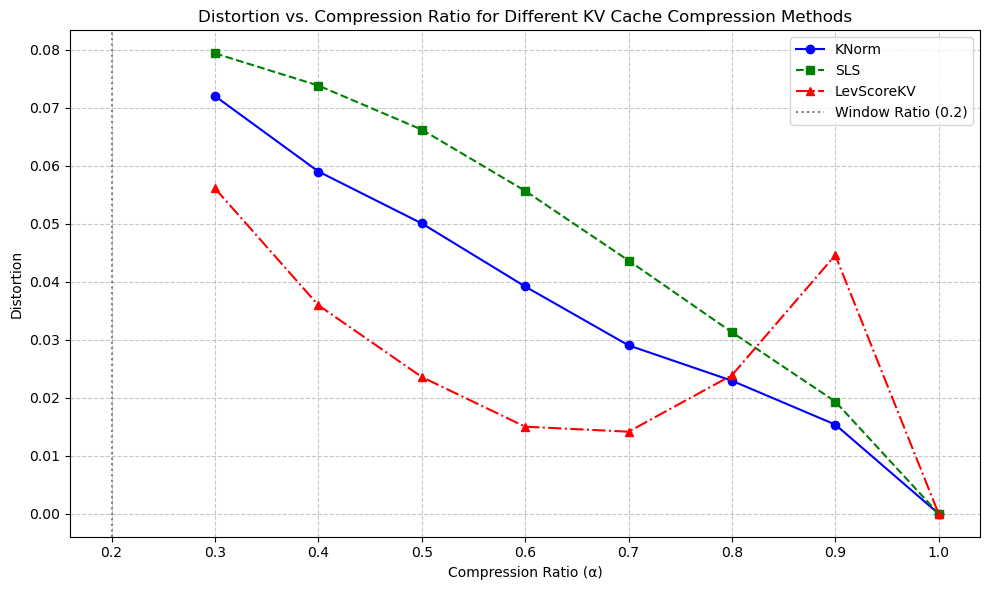

Distortion values at different compression ratios:
Compression Ratio | KNorm | SLS | LevScoreKV
------------------------------------------------------------
0.10 | nan | nan | nan
0.20 | nan | nan | nan
0.30 | 0.0720 | 0.0794 | 0.0561
0.40 | 0.0590 | 0.0738 | 0.0359
0.50 | 0.0501 | 0.0662 | 0.0236
0.60 | 0.0392 | 0.0557 | 0.0150
0.70 | 0.0290 | 0.0437 | 0.0141
0.80 | 0.0229 | 0.0313 | 0.0239
0.90 | 0.0154 | 0.0193 | 0.0446
1.00 | 0.0000 | 0.0000 | 0.0000


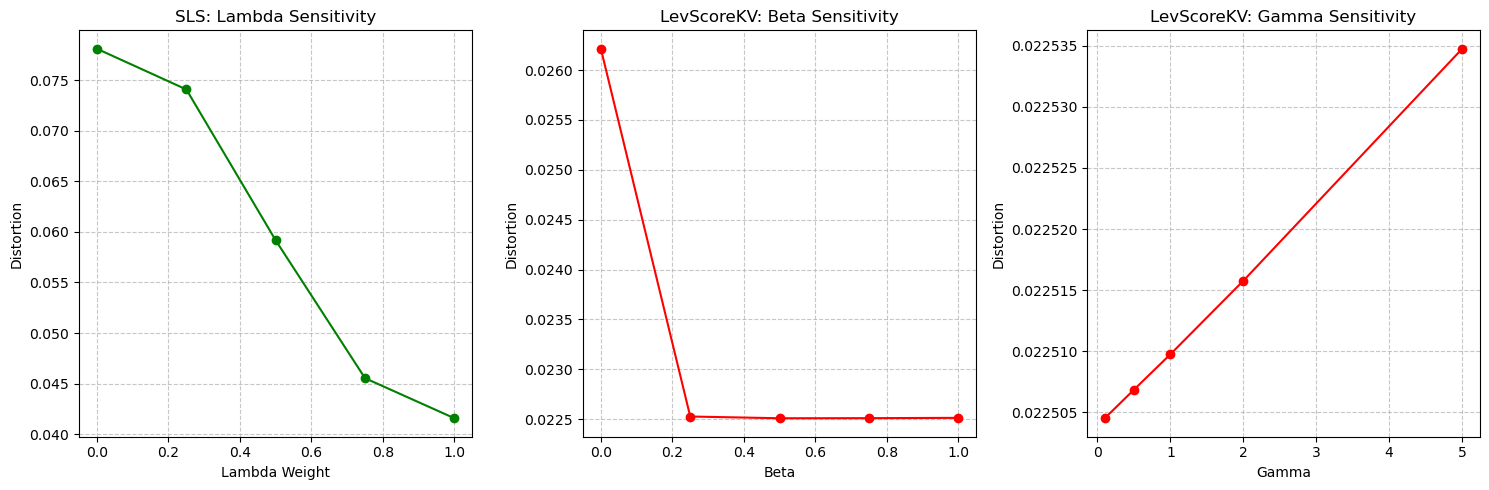

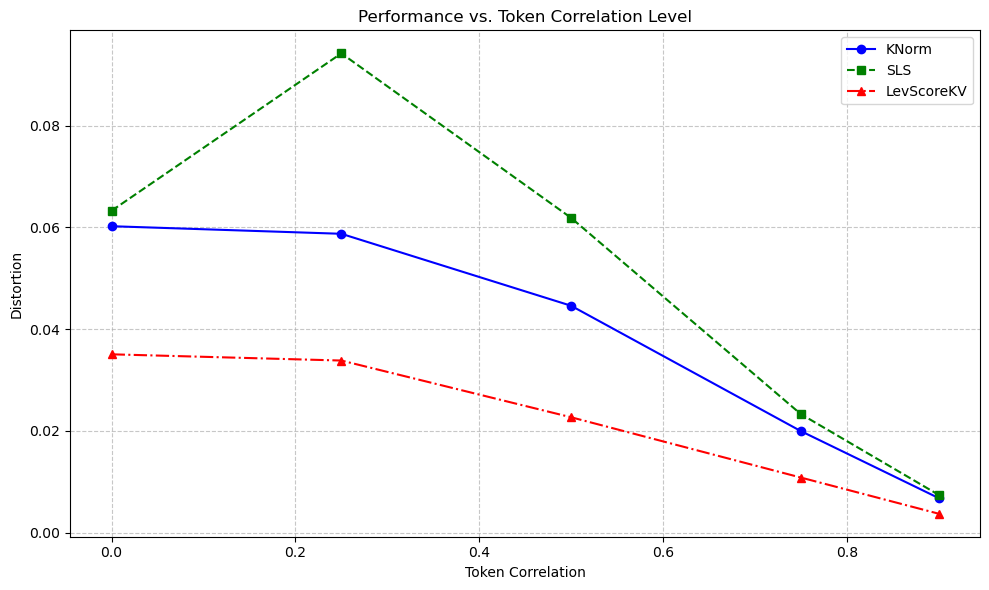

In [15]:
# Example usage:
if __name__ == "__main__":
    # Run main evaluation
    results, compression_ratios = run_evaluation(use_real_model=False)
    
    # Run parameter sensitivity analysis
    param_results = run_parameter_sensitivity_analysis()
    
    # Run correlation experiment
    corr_results, corr_values = run_correlation_experiment()

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


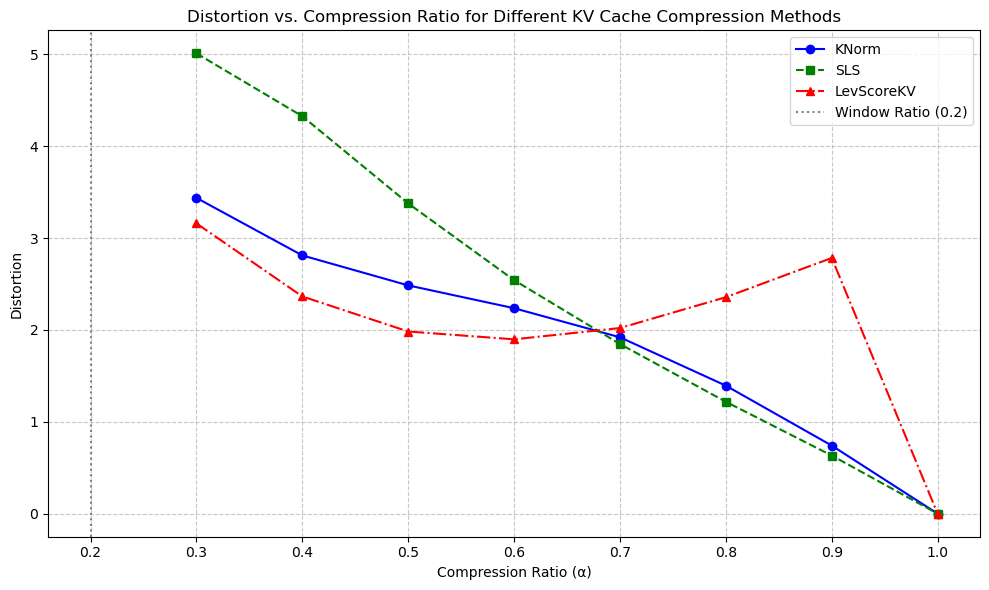

Distortion values at different compression ratios:
Compression Ratio | KNorm | SLS | LevScoreKV
------------------------------------------------------------
0.10 | nan | nan | nan
0.20 | nan | nan | nan
0.30 | 3.4374 | 5.0102 | 3.1597
0.40 | 2.8112 | 4.3260 | 2.3646
0.50 | 2.4849 | 3.3773 | 1.9830
0.60 | 2.2365 | 2.5416 | 1.8978
0.70 | 1.9201 | 1.8467 | 2.0207
0.80 | 1.3936 | 1.2181 | 2.3566
0.90 | 0.7414 | 0.6330 | 2.7834
1.00 | 0.0000 | 0.0000 | 0.0000


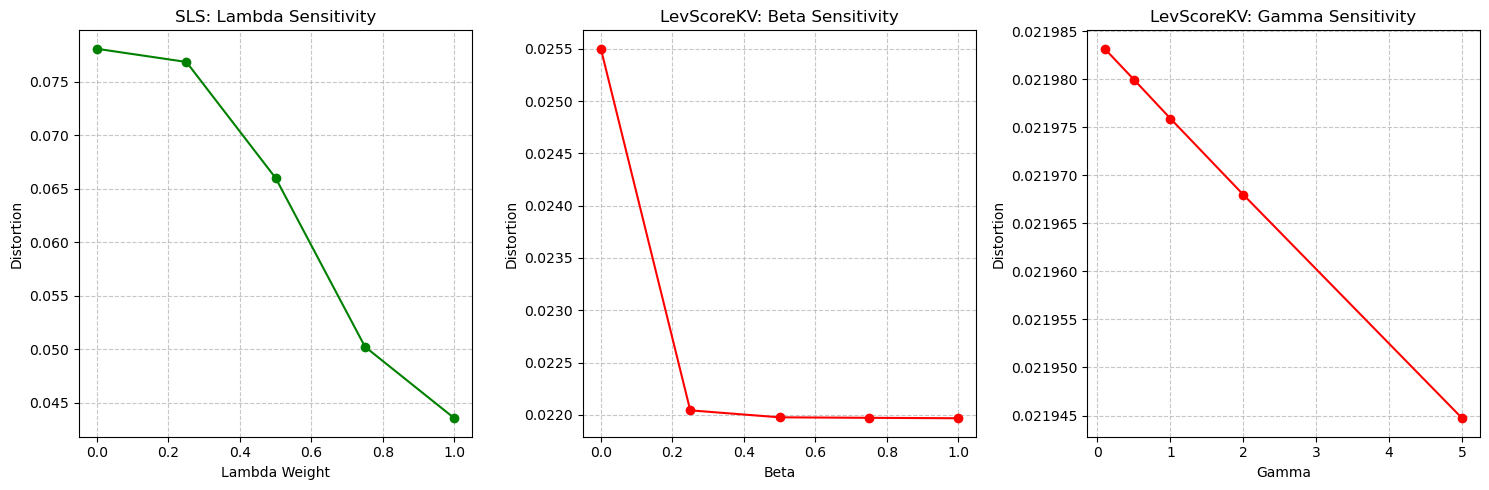

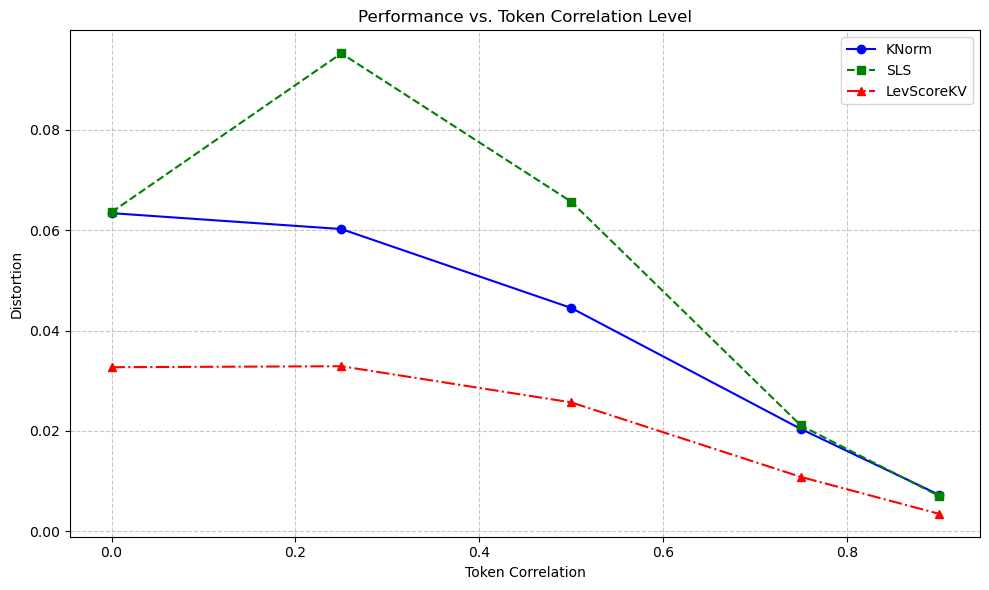

In [16]:
# Example usage:
if __name__ == "__main__":
    # Run main evaluation
    results, compression_ratios = run_evaluation(use_real_model=True)
    
    # Run parameter sensitivity analysis
    param_results = run_parameter_sensitivity_analysis()
    
    # Run correlation experiment
    corr_results, corr_values = run_correlation_experiment()